In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from monai.transforms import (
    CenterSpatialCropd,
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    SpatialPadd,
    ScaleIntensityRangePercentilesd,
    ToTensord,
)

In [2]:
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))
print(os.getcwd())

/home/AR32500/AR32500/MyPapers/box-prompt-learning-VFM/src


## Functions for preprocessing

In [ ]:
def get_val_patient_idx(train_patient_idx=[], num_val_patients=10):
    print('Creating a validation dataset with {} patients'.format(num_val_patients))
    _val_patient_idx = random.sample(train_patient_idx, num_val_patients)
    val_patient_idx = sorted(_val_patient_idx)
    return val_patient_idx


def get_train_test_patient_idx(images_list, num_test_patients=10):
    """_summary_

    Args:
        images_list (list): list of paths to each images (ending with .nii.gz)
        num_test_patients (int, optional): number of test patients. Defaults to 10.

    Returns:
        train_patient_idx (list)
        test_patient_idx (list)
    """        
    # We choose test patients
    patient_name_list = [os.path.basename(path).replace('.nii.gz', '') for path in images_list]
    _test_patient_idx = random.sample(patient_name_list, num_test_patients)
    test_patient_idx = sorted(_test_patient_idx)

    train_patient_idx = [name for name in patient_name_list if name not in test_patient_idx]
        
    return train_patient_idx, test_patient_idx
    
    
def get_train_val_test_list(data_dir, images_list, num_test_patients=10, num_val_patients=10):    
    _train_patient_idx, test_patient_idx = get_train_test_patient_idx(data_dir, images_list, num_test_patients)
    val_patient_idx = get_val_patient_idx(_train_patient_idx, num_val_patients)
    
    assert all(value in _train_patient_idx for value in val_patient_idx)
    train_patient_idx = [idx for idx in _train_patient_idx if idx not in val_patient_idx]
    
    print('train patients:', len(list(train_patient_idx)))
    print('val patients:', len(list(val_patient_idx)))
    print('test patients:', len(list(test_patient_idx)))
    
    return train_patient_idx, val_patient_idx, test_patient_idx

In [4]:
def create_sam_directories(base_dir, type='slice'):
    """Create directories"""
    dir_paths = {}
    if type == 'slice':
        for dataset in ['train', 'val', 'test']:
            for data_type in ['2d_images', '2d_masks']:
                # Construct the directory path
                dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
                dir_paths[f'{dataset}_{data_type}'] = dir_path
                # Create the directory
                os.makedirs(dir_path, exist_ok=True)
    elif type == 'volume':
        for dataset in ["imagesTr", "labelsTr"]:
            # Construct the directory path
            dir_path = os.path.join(base_dir, dataset)
            dir_paths[dataset] = dir_path
            # Create the directory
            os.makedirs(dir_path, exist_ok=True)        
    return dir_paths

def ceil_to_multiple_of_5(n):
    return 5 * np.ceil(n / 5.)

# Preprocessing dataset

In [5]:
data_dir = '/home/AR32500/net/data'
dataset_name = 'HC18'
suffix = '_niigz'

frac_test_patients = 0.2
frac_val_patients = 0.1

remove_background_slices = True
class_list = [1]

crop_pad_size = (640, 640)
new_size = (640, 640) #(no resizing)

In [6]:
raw_data_dir = os.path.join(data_dir, dataset_name, 'raw', 'training_set')
base_dir_slice = os.path.join(data_dir, dataset_name, 'preprocessed_sam')

all_files = os.listdir(os.path.join(data_dir, dataset_name, 'raw', 'training_set'))
# We remove annotations and double images (_2HC)
_patient_name_list = [name for name in all_files if ('_HC' in name and 'Annotation' not in name)]
patient_name_list = sorted(_patient_name_list)

print(len(patient_name_list))

806


In [7]:
patient_name_list

['000_HC.png',
 '001_HC.png',
 '002_HC.png',
 '003_HC.png',
 '004_HC.png',
 '005_HC.png',
 '006_HC.png',
 '007_HC.png',
 '008_HC.png',
 '009_HC.png',
 '010_HC.png',
 '011_HC.png',
 '012_HC.png',
 '013_HC.png',
 '014_HC.png',
 '015_HC.png',
 '016_HC.png',
 '017_HC.png',
 '018_HC.png',
 '019_HC.png',
 '020_HC.png',
 '021_HC.png',
 '022_HC.png',
 '023_HC.png',
 '024_HC.png',
 '025_HC.png',
 '026_HC.png',
 '027_HC.png',
 '028_HC.png',
 '029_HC.png',
 '030_HC.png',
 '031_HC.png',
 '032_HC.png',
 '033_HC.png',
 '034_HC.png',
 '035_HC.png',
 '036_HC.png',
 '037_HC.png',
 '038_HC.png',
 '039_HC.png',
 '040_HC.png',
 '041_HC.png',
 '042_HC.png',
 '043_HC.png',
 '044_HC.png',
 '045_HC.png',
 '046_HC.png',
 '047_HC.png',
 '048_HC.png',
 '049_HC.png',
 '050_HC.png',
 '051_HC.png',
 '052_HC.png',
 '053_HC.png',
 '054_HC.png',
 '055_HC.png',
 '056_HC.png',
 '057_HC.png',
 '058_HC.png',
 '059_HC.png',
 '060_HC.png',
 '061_HC.png',
 '062_HC.png',
 '063_HC.png',
 '064_HC.png',
 '065_HC.png',
 '066_HC.p

In [8]:
# We get train, val and test patient names
num_test_patients = int(ceil_to_multiple_of_5(len(patient_name_list) * frac_test_patients))
num_val_patients = int(len(patient_name_list) * frac_val_patients)
train_patient_idx, val_patient_idx, test_patient_idx = get_train_val_test_list(raw_data_dir, patient_name_list, num_test_patients, num_val_patients)

# Create directories to save preprocessed volumes and slices
dir_paths_slice = create_sam_directories(base_dir_slice, type="slice")
dir_paths_slice

Creating a validation dataset with 80 patients
train patients: 561
val patients: 80
test patients: 165


{'train_2d_images': '/home/AR32500/net/data/HC18/preprocessed_sam/train_2d_images',
 'train_2d_masks': '/home/AR32500/net/data/HC18/preprocessed_sam/train_2d_masks',
 'val_2d_images': '/home/AR32500/net/data/HC18/preprocessed_sam/val_2d_images',
 'val_2d_masks': '/home/AR32500/net/data/HC18/preprocessed_sam/val_2d_masks',
 'test_2d_images': '/home/AR32500/net/data/HC18/preprocessed_sam/test_2d_images',
 'test_2d_masks': '/home/AR32500/net/data/HC18/preprocessed_sam/test_2d_masks'}

In [ ]:
# train_patient_idx = ['000_HC.png', '001_HC.png', '003_HC.png', '004_HC.png', '005_HC.png', '006_HC.png', '007_HC.png', '009_HC.png', '010_HC.png', '011_HC.png', '012_HC.png', '013_HC.png', '015_HC.png', '016_HC.png', '018_HC.png', '019_HC.png', '020_HC.png', '021_HC.png', '022_HC.png', '027_HC.png', '028_HC.png', '029_HC.png', '030_HC.png', '031_HC.png', '032_HC.png', '034_HC.png', '036_HC.png', '037_HC.png', '038_HC.png', '039_HC.png', '041_HC.png', '042_HC.png', '043_HC.png', '044_HC.png', '045_HC.png', '046_HC.png', '047_HC.png', '049_HC.png', '050_HC.png', '051_HC.png', '052_HC.png', '053_HC.png', '054_HC.png', '055_HC.png', '056_HC.png', '057_HC.png', '058_HC.png', '059_HC.png', '061_HC.png', '062_HC.png', '063_HC.png', '066_HC.png', '067_HC.png', '068_HC.png', '069_HC.png', '071_HC.png', '072_HC.png', '073_HC.png', '074_HC.png', '075_HC.png', '077_HC.png', '079_HC.png', '080_HC.png', '081_HC.png', '082_HC.png', '087_HC.png', '088_HC.png', '089_HC.png', '092_HC.png', '093_HC.png', '095_HC.png', '097_HC.png', '099_HC.png', '100_HC.png', '102_HC.png', '104_HC.png', '105_HC.png', '106_HC.png', '107_HC.png', '108_HC.png', '109_HC.png', '110_HC.png', '111_HC.png', '112_HC.png', '113_HC.png', '114_HC.png', '115_HC.png', '116_HC.png', '117_HC.png', '118_HC.png', '119_HC.png', '121_HC.png', '122_HC.png', '124_HC.png', '126_HC.png', '127_HC.png', '128_HC.png', '129_HC.png', '130_HC.png', '131_HC.png', '132_HC.png', '133_HC.png', '135_HC.png', '136_HC.png', '137_HC.png', '140_HC.png', '141_HC.png', '142_HC.png', '143_HC.png', '145_HC.png', '146_HC.png', '147_HC.png', '148_HC.png', '149_HC.png', '150_HC.png', '151_HC.png', '152_HC.png', '153_HC.png', '155_HC.png', '157_HC.png', '158_HC.png', '159_HC.png', '160_HC.png', '161_HC.png', '162_HC.png', '164_HC.png', '165_HC.png', '166_HC.png', '167_HC.png', '169_HC.png', '170_HC.png', '171_HC.png', '172_HC.png', '174_HC.png', '175_HC.png', '176_HC.png', '177_HC.png', '178_HC.png', '179_HC.png', '180_HC.png', '181_HC.png', '183_HC.png', '184_HC.png', '185_HC.png', '188_HC.png', '189_HC.png', '190_HC.png', '192_HC.png', '193_HC.png', '194_HC.png', '195_HC.png', '197_HC.png', '198_HC.png', '199_HC.png', '200_HC.png', '202_HC.png', '203_HC.png', '204_HC.png', '206_HC.png', '207_HC.png', '208_HC.png', '209_HC.png', '211_HC.png', '212_HC.png', '214_HC.png', '215_HC.png', '216_HC.png', '217_HC.png', '218_HC.png', '219_HC.png', '220_HC.png', '221_HC.png', '222_HC.png', '224_HC.png', '226_HC.png', '227_HC.png', '228_HC.png', '229_HC.png', '230_HC.png', '234_HC.png', '235_HC.png', '237_HC.png', '238_HC.png', '240_HC.png', '246_HC.png', '248_HC.png', '250_HC.png', '251_HC.png', '252_HC.png', '253_HC.png', '255_HC.png', '256_HC.png', '257_HC.png', '259_HC.png', '260_HC.png', '261_HC.png', '262_HC.png', '263_HC.png', '264_HC.png', '265_HC.png', '266_HC.png', '267_HC.png', '268_HC.png', '269_HC.png', '271_HC.png', '272_HC.png', '273_HC.png', '274_HC.png', '276_HC.png', '277_HC.png', '278_HC.png', '279_HC.png', '281_HC.png', '284_HC.png', '285_HC.png', '288_HC.png', '291_HC.png', '292_HC.png', '293_HC.png', '295_HC.png', '297_HC.png', '299_HC.png', '300_HC.png', '301_HC.png', '302_HC.png', '303_HC.png', '304_HC.png', '306_HC.png', '308_HC.png', '309_HC.png', '310_HC.png', '312_HC.png', '313_HC.png', '315_HC.png', '316_HC.png', '317_HC.png', '319_HC.png', '320_HC.png', '321_HC.png', '322_HC.png', '323_HC.png', '325_HC.png', '326_HC.png', '328_HC.png', '331_HC.png', '332_HC.png', '333_HC.png', '334_HC.png', '336_HC.png', '337_HC.png', '338_HC.png', '339_HC.png', '340_HC.png', '343_HC.png', '344_HC.png', '345_HC.png', '346_HC.png', '347_HC.png', '348_HC.png', '349_HC.png', '350_HC.png', '351_HC.png', '353_HC.png', '354_HC.png', '355_HC.png', '357_HC.png', '358_HC.png', '359_HC.png', '360_HC.png', '361_HC.png', '362_HC.png', '364_HC.png', '365_HC.png', '367_HC.png', '368_HC.png', '369_HC.png', '370_HC.png', '371_HC.png', '372_HC.png', '375_HC.png', '376_HC.png', '378_HC.png', '380_HC.png', '381_HC.png', '382_HC.png', '383_HC.png', '384_HC.png', '385_HC.png', '387_HC.png', '389_HC.png', '392_HC.png', '393_HC.png', '395_HC.png', '396_HC.png', '398_HC.png', '401_HC.png', '404_HC.png', '406_HC.png', '408_HC.png', '409_HC.png', '411_HC.png', '413_HC.png', '414_HC.png', '415_HC.png', '416_HC.png', '417_HC.png', '418_HC.png', '419_HC.png', '421_HC.png', '422_HC.png', '424_HC.png', '427_HC.png', '429_HC.png', '430_HC.png', '432_HC.png', '433_HC.png', '434_HC.png', '435_HC.png', '437_HC.png', '439_HC.png', '443_HC.png', '445_HC.png', '451_HC.png', '453_HC.png', '454_HC.png', '457_HC.png', '458_HC.png', '461_HC.png', '462_HC.png', '463_HC.png', '464_HC.png', '465_HC.png', '467_HC.png', '470_HC.png', '471_HC.png', '472_HC.png', '474_HC.png', '475_HC.png', '477_HC.png', '478_HC.png', '479_HC.png', '480_HC.png', '481_HC.png', '482_HC.png', '483_HC.png', '484_HC.png', '485_HC.png', '486_HC.png', '487_HC.png', '488_HC.png', '489_HC.png', '494_HC.png', '495_HC.png', '496_HC.png', '498_HC.png', '500_HC.png', '501_HC.png', '503_HC.png', '504_HC.png', '506_HC.png', '507_HC.png', '509_HC.png', '511_HC.png', '512_HC.png', '513_HC.png', '514_HC.png', '515_HC.png', '516_HC.png', '519_HC.png', '520_HC.png', '521_HC.png', '522_HC.png', '526_HC.png', '527_HC.png', '528_HC.png', '529_HC.png', '530_HC.png', '532_HC.png', '533_HC.png', '535_HC.png', '536_HC.png', '537_HC.png', '538_HC.png', '539_HC.png', '540_HC.png', '542_HC.png', '543_HC.png', '544_HC.png', '546_HC.png', '548_HC.png', '550_HC.png', '554_HC.png', '555_HC.png', '556_HC.png', '557_HC.png', '560_HC.png', '561_HC.png', '562_HC.png', '565_HC.png', '567_HC.png', '568_HC.png', '569_HC.png', '570_HC.png', '571_HC.png', '572_HC.png', '573_HC.png', '574_HC.png', '576_HC.png', '579_HC.png', '580_HC.png', '582_HC.png', '584_HC.png', '587_HC.png', '588_HC.png', '589_HC.png', '590_HC.png', '592_HC.png', '593_HC.png', '594_HC.png', '595_HC.png', '596_HC.png', '598_HC.png', '599_HC.png', '600_HC.png', '601_HC.png', '602_HC.png', '603_HC.png', '604_HC.png', '607_HC.png', '608_HC.png', '610_HC.png', '611_HC.png', '613_HC.png', '616_HC.png', '618_HC.png', '619_HC.png', '620_HC.png', '621_HC.png', '622_HC.png', '623_HC.png', '624_HC.png', '627_HC.png', '630_HC.png', '631_HC.png', '633_HC.png', '634_HC.png', '635_HC.png', '636_HC.png', '637_HC.png', '638_HC.png', '640_HC.png', '643_HC.png', '645_HC.png', '647_HC.png', '648_HC.png', '650_HC.png', '651_HC.png', '652_HC.png', '653_HC.png', '655_HC.png', '656_HC.png', '657_HC.png', '658_HC.png', '659_HC.png', '660_HC.png', '661_HC.png', '664_HC.png', '667_HC.png', '670_HC.png', '672_HC.png', '673_HC.png', '674_HC.png', '676_HC.png', '677_HC.png', '678_HC.png', '679_HC.png', '680_HC.png', '681_HC.png', '684_HC.png', '687_HC.png', '688_HC.png', '689_HC.png', '690_HC.png', '691_HC.png', '692_HC.png', '694_HC.png', '695_HC.png', '696_HC.png', '697_HC.png', '698_HC.png', '699_HC.png', '700_HC.png', '702_HC.png', '704_HC.png', '705_HC.png', '706_HC.png', '707_HC.png', '712_HC.png', '713_HC.png', '715_HC.png', '716_HC.png', '717_HC.png', '718_HC.png', '719_HC.png', '720_HC.png', '723_HC.png', '724_HC.png', '725_HC.png', '726_HC.png', '727_HC.png', '730_HC.png', '731_HC.png', '733_HC.png', '735_HC.png', '738_HC.png', '740_HC.png', '741_HC.png', '742_HC.png', '743_HC.png', '745_HC.png', '746_HC.png', '747_HC.png', '748_HC.png', '749_HC.png', '753_HC.png', '754_HC.png', '756_HC.png', '758_HC.png', '760_HC.png', '761_HC.png', '765_HC.png', '766_HC.png', '767_HC.png', '768_HC.png', '769_HC.png', '770_HC.png', '771_HC.png', '775_HC.png', '777_HC.png', '778_HC.png', '780_HC.png', '781_HC.png', '782_HC.png', '784_HC.png', '785_HC.png', '786_HC.png', '787_HC.png', '788_HC.png', '789_HC.png', '790_HC.png', '791_HC.png', '792_HC.png', '793_HC.png', '794_HC.png', '795_HC.png', '796_HC.png', '797_HC.png', '800_HC.png', '802_HC.png', '804_HC.png', '805_HC.png']
# val_patient_idx = ['008_HC.png', '024_HC.png', '026_HC.png', '040_HC.png', '064_HC.png', '078_HC.png', '085_HC.png', '090_HC.png', '091_HC.png', '123_HC.png', '125_HC.png', '139_HC.png', '156_HC.png', '168_HC.png', '182_HC.png', '205_HC.png', '213_HC.png', '223_HC.png', '225_HC.png', '239_HC.png', '241_HC.png', '242_HC.png', '244_HC.png', '270_HC.png', '275_HC.png', '286_HC.png', '289_HC.png', '290_HC.png', '296_HC.png', '311_HC.png', '324_HC.png', '329_HC.png', '366_HC.png', '379_HC.png', '386_HC.png', '391_HC.png', '402_HC.png', '405_HC.png', '410_HC.png', '412_HC.png', '425_HC.png', '428_HC.png', '438_HC.png', '447_HC.png', '449_HC.png', '452_HC.png', '459_HC.png', '469_HC.png', '491_HC.png', '492_HC.png', '493_HC.png', '497_HC.png', '502_HC.png', '510_HC.png', '531_HC.png', '547_HC.png', '563_HC.png', '575_HC.png', '583_HC.png', '586_HC.png', '597_HC.png', '605_HC.png', '609_HC.png', '617_HC.png', '628_HC.png', '632_HC.png', '639_HC.png', '641_HC.png', '662_HC.png', '683_HC.png', '686_HC.png', '734_HC.png', '737_HC.png', '739_HC.png', '751_HC.png', '752_HC.png', '773_HC.png', '774_HC.png', '779_HC.png', '799_HC.png']
# test_patient_idx = ['002_HC.png', '014_HC.png', '017_HC.png', '023_HC.png', '025_HC.png', '033_HC.png', '035_HC.png', '048_HC.png', '060_HC.png', '065_HC.png', '070_HC.png', '076_HC.png', '083_HC.png', '084_HC.png', '086_HC.png', '094_HC.png', '096_HC.png', '098_HC.png', '101_HC.png', '103_HC.png', '120_HC.png', '134_HC.png', '138_HC.png', '144_HC.png', '154_HC.png', '163_HC.png', '173_HC.png', '186_HC.png', '187_HC.png', '191_HC.png', '196_HC.png', '201_HC.png', '210_HC.png', '231_HC.png', '232_HC.png', '233_HC.png', '236_HC.png', '243_HC.png', '245_HC.png', '247_HC.png', '249_HC.png', '254_HC.png', '258_HC.png', '280_HC.png', '282_HC.png', '283_HC.png', '287_HC.png', '294_HC.png', '298_HC.png', '305_HC.png', '307_HC.png', '314_HC.png', '318_HC.png', '327_HC.png', '330_HC.png', '335_HC.png', '341_HC.png', '342_HC.png', '352_HC.png', '356_HC.png', '363_HC.png', '373_HC.png', '374_HC.png', '377_HC.png', '388_HC.png', '390_HC.png', '394_HC.png', '397_HC.png', '399_HC.png', '400_HC.png', '403_HC.png', '407_HC.png', '420_HC.png', '423_HC.png', '426_HC.png', '431_HC.png', '436_HC.png', '440_HC.png', '441_HC.png', '442_HC.png', '444_HC.png', '446_HC.png', '448_HC.png', '450_HC.png', '455_HC.png', '456_HC.png', '460_HC.png', '466_HC.png', '468_HC.png', '473_HC.png', '476_HC.png', '490_HC.png', '499_HC.png', '505_HC.png', '508_HC.png', '517_HC.png', '518_HC.png', '523_HC.png', '524_HC.png', '525_HC.png', '534_HC.png', '541_HC.png', '545_HC.png', '549_HC.png', '551_HC.png', '552_HC.png', '553_HC.png', '558_HC.png', '559_HC.png', '564_HC.png', '566_HC.png', '577_HC.png', '578_HC.png', '581_HC.png', '585_HC.png', '591_HC.png', '606_HC.png', '612_HC.png', '614_HC.png', '615_HC.png', '625_HC.png', '626_HC.png', '629_HC.png', '642_HC.png', '644_HC.png', '646_HC.png', '649_HC.png', '654_HC.png', '663_HC.png', '665_HC.png', '666_HC.png', '668_HC.png', '669_HC.png', '671_HC.png', '675_HC.png', '682_HC.png', '685_HC.png', '693_HC.png', '701_HC.png', '703_HC.png', '708_HC.png', '709_HC.png', '710_HC.png', '711_HC.png', '714_HC.png', '721_HC.png', '722_HC.png', '728_HC.png', '729_HC.png', '732_HC.png', '736_HC.png', '744_HC.png', '750_HC.png', '755_HC.png', '757_HC.png', '759_HC.png', '762_HC.png', '763_HC.png', '764_HC.png', '772_HC.png', '776_HC.png', '783_HC.png', '798_HC.png', '801_HC.png', '803_HC.png']

In [14]:
# Added ScaleIntensityRangePercentilesd on Feb 14th 2024
transforms = Compose([
    LoadImaged(keys=["img", "label"]),  # load .nii or .nii.gz files
    EnsureChannelFirstd(keys=['img', 'label']),
    CenterSpatialCropd(keys=['img', 'label'], roi_size=crop_pad_size), # maximum size set to 40 x 40 (can be smaller if input img size smaller)
    SpatialPadd(keys=["img", "label"], spatial_size=crop_pad_size), # pad if size smaller than 512 x 512 --> get size 512 x 512 (since already cropped)
    Resized(keys=["img", "label"], spatial_size=new_size, mode=['bilinear', 'nearest']),
    ScaleIntensityRangePercentilesd(keys=["img"], 
                     lower=0.5,  upper=99.5,  # This should call the percentile_scale function to get the 95th percentile
                      b_min=0, b_max=255, clip=True),
    ToTensord(keys=["img", "label"])
    ])

000_HC.png
001_HC.png
002_HC.png
003_HC.png
004_HC.png


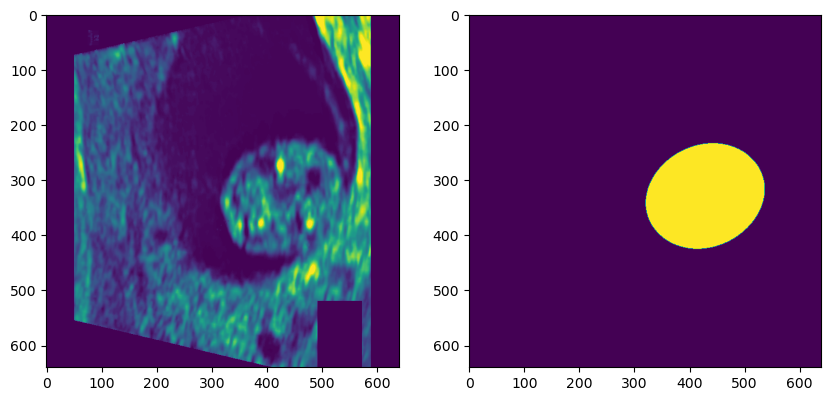

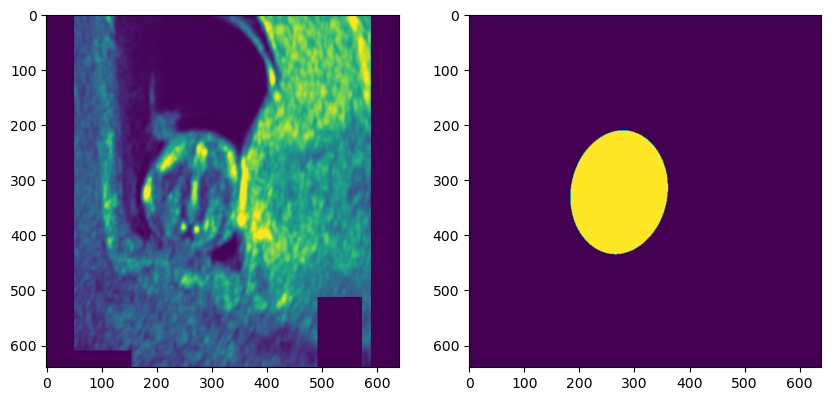

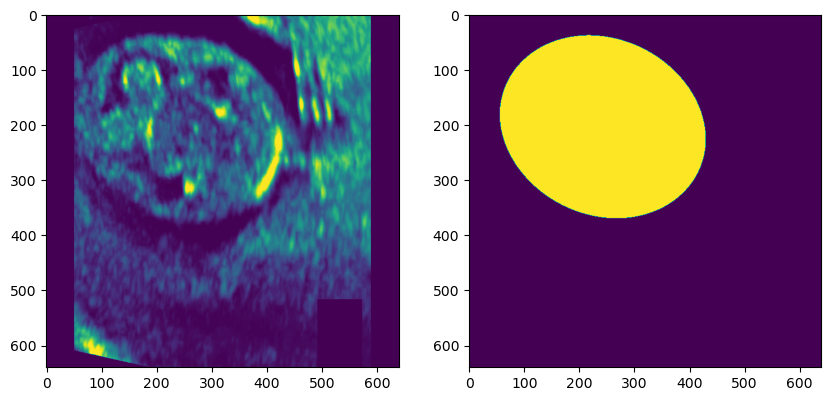

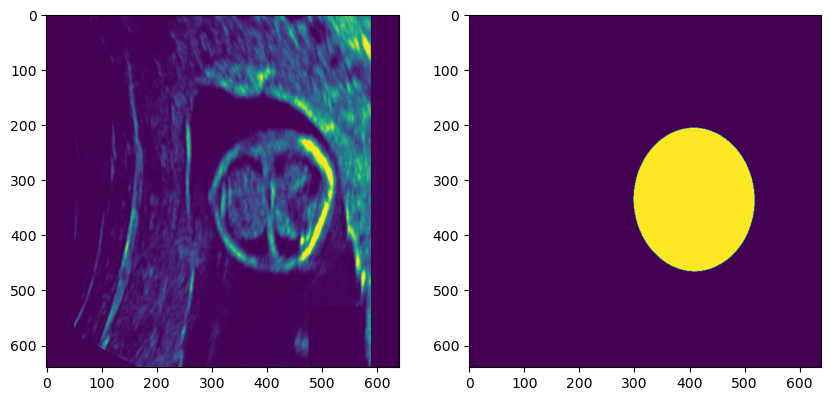

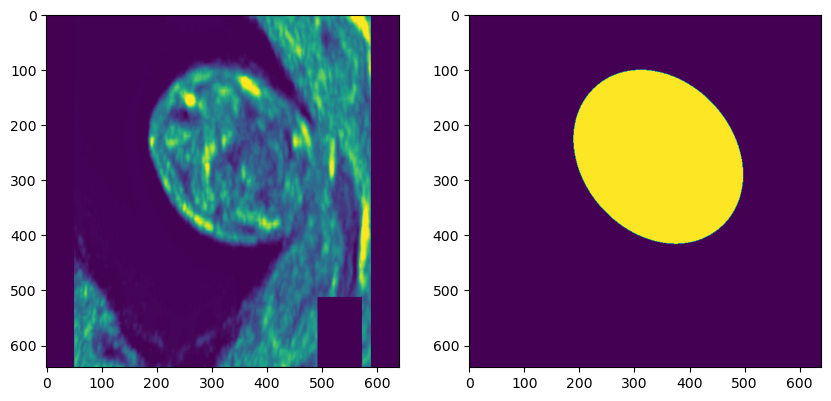

In [ ]:
for patient_name in patient_name_list:
    img_path = os.path.join(data_dir, dataset_name, 'raw', 'training_set', patient_name) 
    mask_path = os.path.join(data_dir, dataset_name, 'raw', 'training_set', patient_name.replace('.png', '_Annotation.png')) 

    data_dict = transforms({'img': img_path, 'label': mask_path})
    img = data_dict['img'][0, :, :].astype(np.uint8)
    mask = data_dict['label'][0, :, :].astype(np.uint8)
    
    # We fill up the contours given to obtain a mask
    try:
        contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        empty_mask = np.zeros(img.shape, np.uint8)
        mask = cv2.drawContours(empty_mask, contours, 1, (1), thickness=cv2.FILLED)
        
        print(patient_name)

        # Select appropriate directories
        if patient_name in train_patient_idx:  # Training
            img_dir = dir_paths_slice['train_2d_images']
            mask_dir = dir_paths_slice['train_2d_masks']
        elif patient_name in val_patient_idx:  # Validation
            img_dir = dir_paths_slice['val_2d_images']
            mask_dir = dir_paths_slice['val_2d_masks']
        else:  # Testing
            img_dir = dir_paths_slice['test_2d_images']
            mask_dir = dir_paths_slice['test_2d_masks']

        # Define the output paths
        filename = os.path.basename(img_path).replace('.png', '.nii.gz')
        img_slice_path = os.path.join(img_dir, filename)
        mask_slice_path = os.path.join(mask_dir, filename)

        sitk.WriteImage(sitk.GetImageFromArray(img), img_slice_path)
        sitk.WriteImage(sitk.GetImageFromArray(mask), mask_slice_path)

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(121)
        ax.imshow(img)
        ax = fig.add_subplot(122)
        ax.imshow(mask)
        
    except Exception as e:
        print('Issue with file {}: {}'.format(patient_name, e))
